# XGBoost

## Setup

In [1]:
import os
import sys
import importlib

LIB_DIR = './lib'
SAVED_MODELS_DIR = '../backend/saved_models'

os.makedirs(LIB_DIR, exist_ok=True)
sys.path.append(LIB_DIR)
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
sys.path.append(SAVED_MODELS_DIR)

def install_package(package_name):
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed")
    except ImportError:
        print(f"Installing {package_name}")
        %pip install --quiet $package_name --progress-bar on

def download_lib(filename, url):
    LIB_PATH = os.path.join(LIB_DIR, filename)
    if not os.path.exists(LIB_PATH):
        print(f"Downloading {filename}")
        import urllib.request
        urllib.request.urlretrieve(url, LIB_PATH)
        print(f"Downloaded {filename} to {LIB_PATH}")
    else:
        print(f"{filename} already downloaded")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import joblib

download_lib("visualization.py", "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py")

import visualization # type: ignore
from visualization import plot_conf_mat # type: ignore
importlib.reload(visualization)

from lib.utils import make_serializable

install_package("xgboost")
install_package("setuptools")
install_package("hyperopt")
from xgboost import XGBClassifier, plot_importance
from hyperopt import STATUS_OK, Trials, hp, fmin, tpe
import shap
import matplotlib.pyplot as plt

visualization.py already downloaded
xgboost is already installed
setuptools is already installed
hyperopt is already installed


In [2]:
files_path = ''

if 'google.colab' in str(get_ipython()): # type: ignore
    print('TO DO: Set up Google Colab')
    # print('Running in Google Colab')
    # from google.colab import drive
    # mount_point = '/content/drive'
    # drive.mount(mount_point)
    # files_path = mount_point + '/MyDrive/Colab Notebooks/'
else:
    print('Running locally')
    files_path = '../data/'

Running locally


In [3]:
german_df = pd.read_csv(files_path + 'syntetic_sample.csv')

In [4]:
mappings = {
    'sex': {
        'female': 0,
        'male': 1
    },
    'present_employee_since': {
        'unemployed': 0, '<1y': 1, '1-4y': 2, '4-7y': 3, '>=7y': 4
    },
    'checking_account': {
        'no checking account': 0, '< 0 DM': 1, '0 <= ... < 200 DM': 2, '>= 200 DM': 3
    },
    'savings': {
        '0 or unk.': 0, '<100 DM': 1, '100-500 DM': 2, '500-1000 DM': 3, '>1000 DM': 4
    },
    'job': {
        'unemployed/unskilled non-resident': 0,
        'unskilled resident': 1,
        'qualified': 2,
        'highly qualified': 3
    }
}

german_preprocessed_df = german_df.copy()

for col, mapping in mappings.items():
    german_preprocessed_df[col] = german_preprocessed_df[col].map(mapping).astype(int)

In [5]:
german_dummies_df = pd.get_dummies(german_preprocessed_df, dtype=int, drop_first=True)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    german_dummies_df.drop(columns=['risk']),
    german_dummies_df['risk'],
    test_size=0.2,
    random_state=42
)

In [7]:
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'early_stopping_rounds': 10,
    'max_depth': hp.quniform("max_depth", 3, 12, 1),
    'gamma': hp.uniform ('gamma', 0, 5),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 100, 5),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'seed': 42,
}

def objective(params):
    model = XGBClassifier(
        objective=params['objective'],
        eval_metric=params['eval_metric'],
        early_stopping_rounds=params['early_stopping_rounds'],
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        reg_alpha=int(params['reg_alpha']),
        min_child_weight=int(params['min_child_weight']),
        colsample_bytree=params['colsample_bytree'],
        reg_lambda=params['reg_lambda'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        seed=params['seed']
    )

    evaluation = [(x_train, y_train), (x_test, y_test)]
    model.fit(x_train, y_train, eval_set=evaluation, verbose=False)

    y_pred = model.predict(x_test)
    f1_scr = f1_score(y_test, y_pred)

    return {'loss': -f1_scr, 'status': STATUS_OK}

best_hyperparams = None
best_model = None

if not os.path.exists(SAVED_MODELS_DIR + '/xgboost.pkl'):
    print("No saved model found, starting hyperparameter optimization...")
    trials = Trials()
    best_hyperparams = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=10,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    best_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        # early_stopping_rounds=10,
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        # gamma=best_hyperparams['gamma'],
        reg_alpha=float(best_hyperparams['reg_alpha']),
        min_child_weight=int(best_hyperparams['min_child_weight']),
        # colsample_bytree=best_hyperparams['colsample_bytree'],
        # reg_lambda=best_hyperparams['reg_lambda'],
        # learning_rate=best_hyperparams['learning_rate'],
        # subsample=best_hyperparams['subsample'],
    seed=42
    )
    best_model.fit(x_train, y_train)
else:
    print("Loading saved model...")
    best_model = joblib.load(SAVED_MODELS_DIR + '/xgboost.pkl')["model"]
    best_hyperparams = best_model.get_xgb_params()
    print("Model loaded successfully.")

print("Best hyperparameters:", best_hyperparams)

Loading saved model...
Model loaded successfully.
Best hyperparameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': 'logloss', 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 12, 'max_leaves': None, 'min_child_weight': 5, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 10.0, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'seed': 42}


In [8]:
best_model.predict_proba(x_test)

array([[0.0108934 , 0.9891066 ],
       [0.4839235 , 0.5160765 ],
       [0.9968704 , 0.00312962],
       ...,
       [0.00150549, 0.9984945 ],
       [0.44367033, 0.55632967],
       [0.56322384, 0.4367762 ]], shape=(200000, 2), dtype=float32)

In [9]:
y_pred = best_model.predict(x_test)
y_pred

array([1, 1, 0, ..., 1, 1, 0], shape=(200000,))

In [10]:
class_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85     60005
           1       0.93      0.94      0.94    139995

    accuracy                           0.91    200000
   macro avg       0.90      0.89      0.90    200000
weighted avg       0.91      0.91      0.91    200000



In [11]:
print("Final f1-score:", f1_score(y_test, y_pred))

Final f1-score: 0.9378489259574225


Normalized confusion matrix
[[0.84569619 0.15430381]
 [0.05863067 0.94136933]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

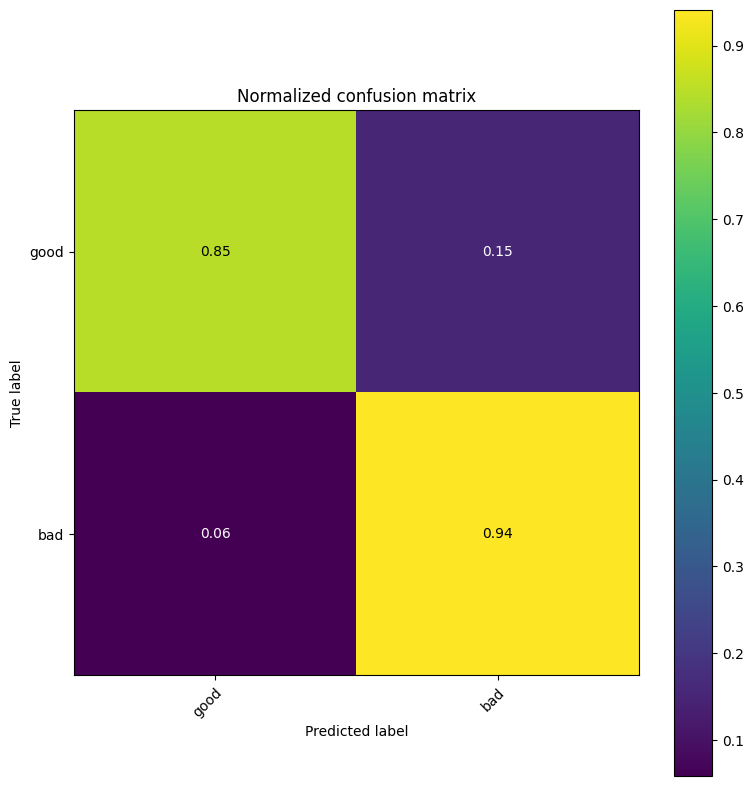

In [12]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = np.array(['good', 'bad'])
plot_conf_mat(y_test, y_pred, class_names)

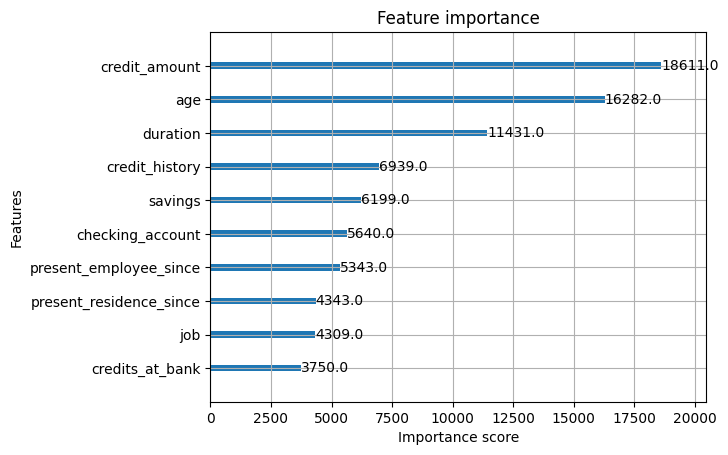

In [13]:
# Explainable AI
plot_importance(best_model, max_num_features=10, importance_type='weight')
plt.show()

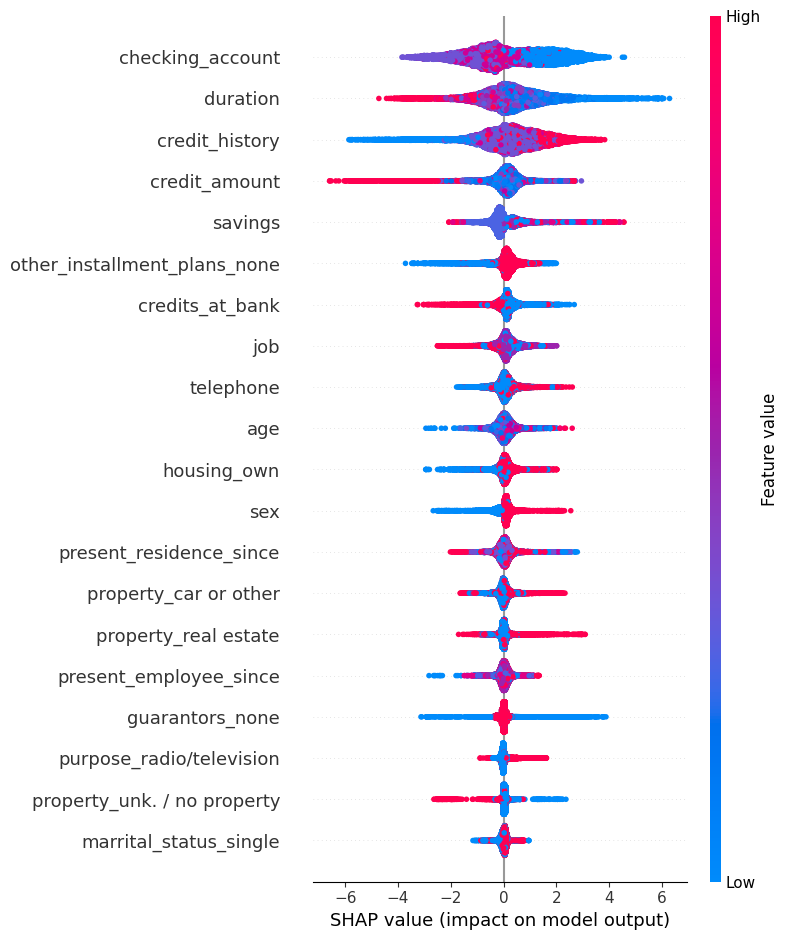

In [14]:
x_test_xai = x_test.sample(frac=0.1, random_state=42)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(x_test_xai)

shap.summary_plot(shap_values, x_test_xai)

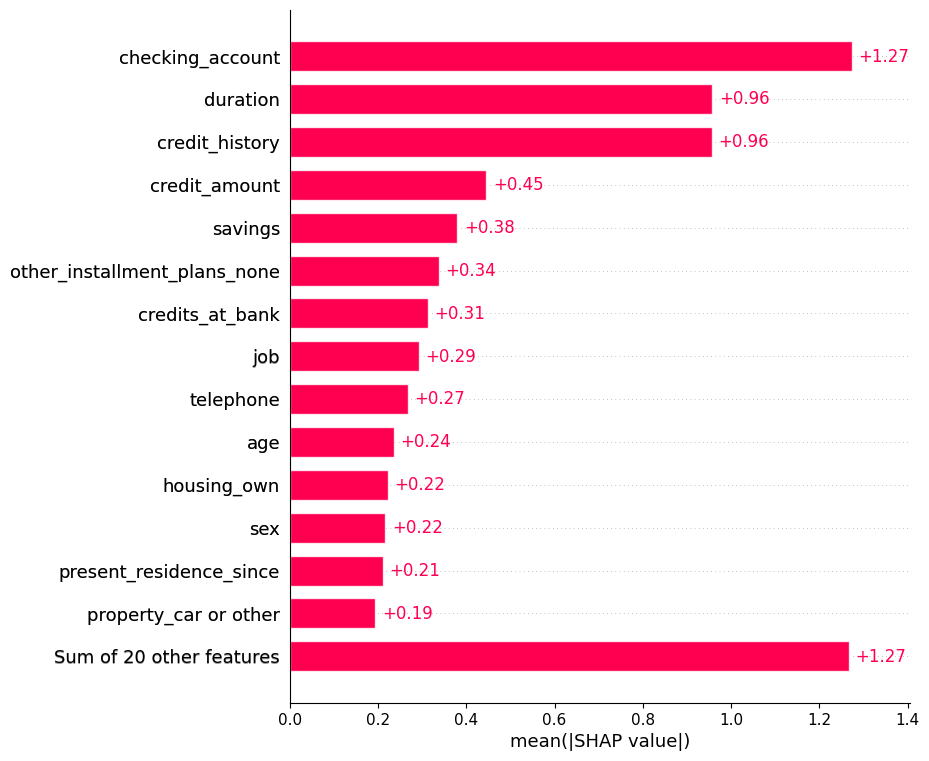

In [15]:
shap.plots.bar(shap_values, max_display=15)

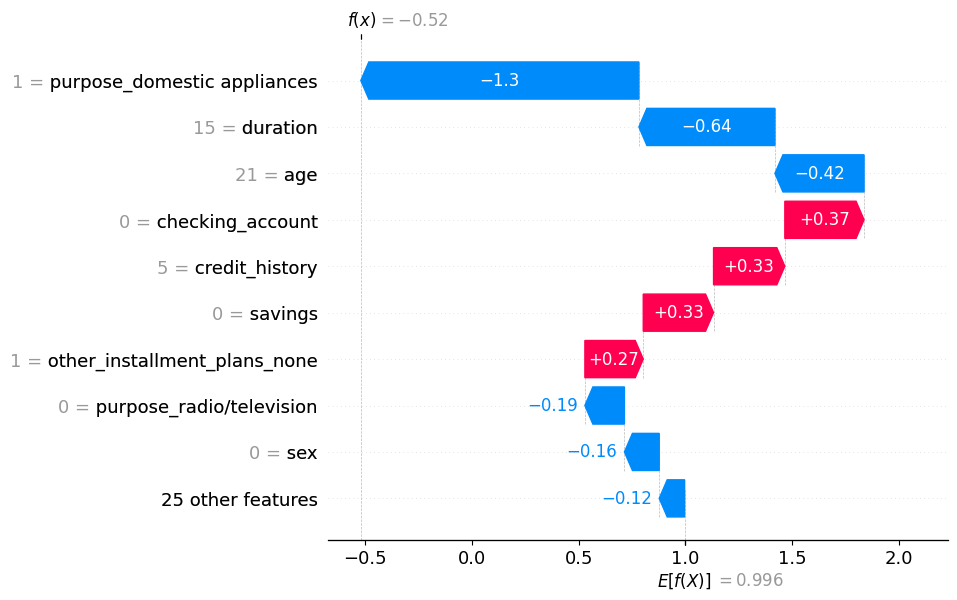

In [16]:
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx])

In [18]:
shap_data = {
    "shap_values": shap_values.values.tolist(),
    "data": x_test_xai,
    "feature_names": x_test_xai.columns.tolist(),
}

metrics = {
    "confusion_matrix": cm_normalized,
    "classification_report": class_report,
}

joblib.dump({
    "model": best_model,
    "metrics": make_serializable(metrics),
    "shap": shap_data,
    }, SAVED_MODELS_DIR + '/xgboost.pkl')

['../backend/saved_models/xgboost.pkl']